In [2]:
import pandas as pd

import scipy as sc
from scipy.io import loadmat

import numpy as np

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

from matplotlib import pyplot as plt
%matplotlib inline

import time

import util
from util import *
import plot


np.random.seed(123)

## Prepare

1. Features: 
   - kernel of all features
   - kernel of each feature
   - gaussian, polynomial
   
2. Features preprocessing:
   - normalization of the features
   - spherical normalization of kernel matrices
   
3. levels of sparsity


# Read Data

### sonar Data

In [9]:
reload(util)


X_sonar, y_sonar  = util.get_sonar_data()
#X_sonar, y_sonar = sonar_data[:,:-1], sonar_data[:,-1]
X_sonar = util.preprocess_feats(X_sonar)


N = 144 #int(X_sonar.shape[0]*.75)

K_sonar = util.get_kernels(X_sonar, poly=True, feat_kernel=True, gauss=True, max_gauss_width=3, min_gauss_width=-1)
#K_sonar = util.get_kernels(X_sonar, poly=True, feat_kernel=False, gauss=False)

K_sonar = util.preprocess_kernel(K_sonar)
K, K_test = K_sonar[:,:N,:N],K_sonar[:,N:,:N]
y, y_test = y_sonar[:N], y_sonar[N:]

In [4]:
X_sonar[0],X_sonar.shape

(array([0.02, 0.0371, 0.0428, 0.0207, 0.0954, 0.0986, 0.1539, 0.1601,
        0.3109, 0.2111, 0.1609, 0.1582, 0.2238, 0.0645, 0.066, 0.2273,
        0.31, 0.2999, 0.5078, 0.4797, 0.5783, 0.5071, 0.4328, 0.555,
        0.6711, 0.6415, 0.7104, 0.808, 0.6791, 0.3857, 0.1307, 0.2604,
        0.5121, 0.7547, 0.8537, 0.8507, 0.6692, 0.6097, 0.4943, 0.2744,
        0.051, 0.2834, 0.2825, 0.4256, 0.2641, 0.1386, 0.1051, 0.1343,
        0.0383, 0.0324, 0.0232, 0.0027, 0.0065, 0.0159, 0.0072, 0.0167,
        0.018, 0.0084, 0.009, 0.0032], dtype=object), (208, 60))

In [7]:
P = K.shape[0]

print 'Kernels:', P

Kernels: 488


## Plot Data

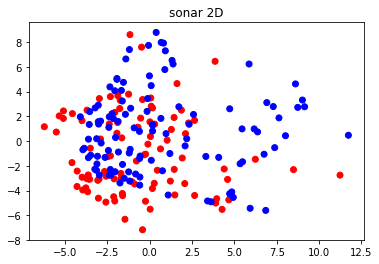

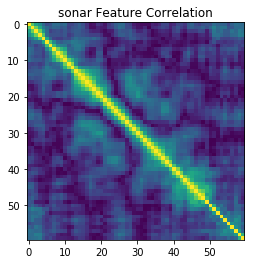

In [6]:
reload(plot)
plot.plot_data(X_sonar,y_sonar, 'sonar')


## Plot Kernels

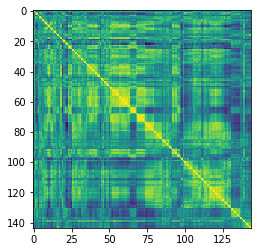

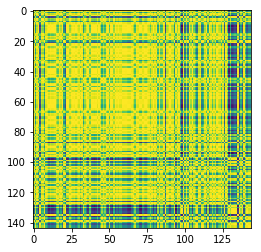

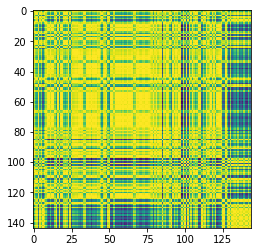

In [8]:
for i in range(3):
    plot.plot_kernel(K[i,...],'sonar_k%d'%i)

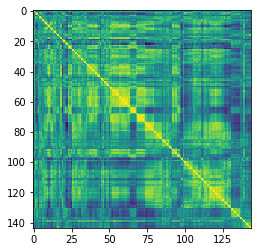

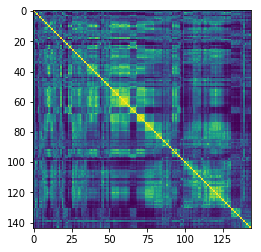

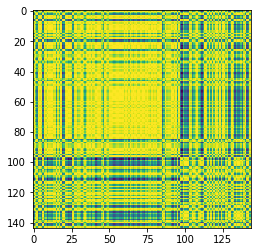

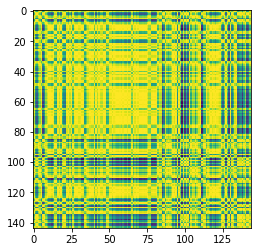

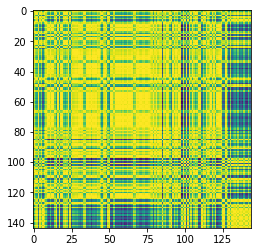

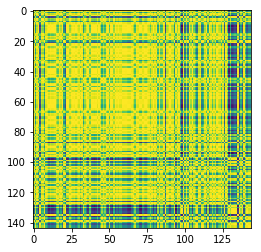

In [12]:
for i in range(2):
    plot.plot_kernel(K[i,...],'sonar_k%d'%i)
    
for i in range(11,7,-1):
    plot.plot_kernel(K[i,...],'sonar_k%d'%i)

# BEMKL

- Sparsity: #chosen kernels
- Running time: 
- Accuracy:

# Non-Sparse

### One time Evaluation 

In [13]:
import bemkl_binary

nsp_clf = bemkl_binary.BEMKL(sparse=False)

t1 = time.time()

nsp_clf.bemkl_binary(K,y)

t2 = time.time()
diff = t2 - t1

pred, prob = nsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

MemoryError: 

### Cross Validation

In [27]:
reload(bemkl_binary)

cv_folds = 5
t1 = time.time()

nsp_clf = bemkl_binary.BEMKL(sparse=False)
nsp_clf.evaluate_model(K_sonar,y_sonar)

t2 = time.time()
diff = t2 - t1

print 'Mean training time:', diff/cv_folds
print 'Total training time:', diff

Mean Accuracy: 0.775
Mean Training Time: 116.44348607063293
Mean training time: 119.532286215
Total training time: 597.661431074


In [7]:
'''k_acc = np.empty(K.shape[0])

for kidx in range(1,K.shape[0],5):
    clf = bemkl_binary.BEMKL(sparse=sparse)

    clf.bemkl_binary(K[:kidx,...],y)

    pred, prob = clf.predict(K_test[:kidx,...])

    print 'Accuracy:'
    k_acc[kidx] = (pred==y_test).sum()*1./y_test.shape[0]
    print k_acc[kidx]'''

Accuracy:
0.8071428571428572


## Sparse

In [71]:
sp_clf = bemkl_binary.BEMKL(sparse=True)

t1 = time.time()

sp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = sp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8047619047619048
Training Time: 16.4168908596


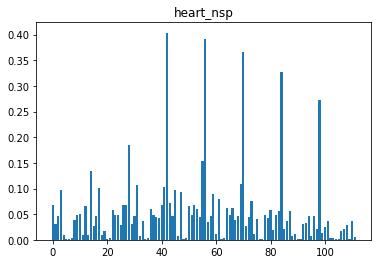

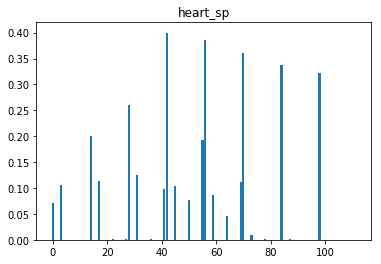

In [73]:
plot.plot_results(nsp_clf, 'sonar')
plot.plot_results(sp_clf, 'sonar')

In [78]:
weight_threshold = 1e-3

print 'Nmber of Chosen Kernels:'
print (sp_clf.mu_b_e > weight_threshold).sum()

Nmber of Chosen Kernels:
22


In [ ]:
'''reload(bemkl_binary)

cv_folds = 5
t1 = time.time()

clf = bemkl_binary.BEMKL(sparse=True)
clf.evaluate_model(K_sonar,y_sonar)

t2 = time.time()
diff = t2 - t1

print 'Mean training time:', diff/cv_folds
print 'Total training time:', diff'''

In [ ]:
plt.bar(np.arange(K.shape[0]), np.diag(cov_b_e_nsp)[1:])

In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_ylim(0,.01)
plt.bar(np.arange(K.shape[0]-1), mu_b_e_sp[1:], figure=fig)
ax.bar(np.arange(K.shape[0]-1), np.diag(cov_b_e_sp)[1:],  color='r')

plt.show()
#fig.savefig('sonar_sp_k.png', dpi=400, transparent=True, bbox_inches='tight')




In [91]:
map(lambda x: 2.**x, np.arange(-3,7))

[0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]

In [15]:
K.shape

(112, 500, 500)

In [44]:
idx = np.arange(0,300,5)
print idx.shape

a = np.copy(K[:,idx][:,:,idx])
%timeit np.dot(a,a.T)

(60,)
1 loop, best of 3: 3.09 s per loop


In [45]:
a = np.copy(K[:,:60][...,:60])
%timeit np.dot(a,a.T)

1 loop, best of 3: 5.13 s per loop
